<a href="https://colab.research.google.com/github/JinCui0508/minder-project/blob/main/onehotencoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')
import os
root_dir = '//content/drive/My Drive/llm/code'

print(root_dir)
os.chdir(root_dir)
from pathlib import Path
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns
import tqdm
import torch
# !pip install sentence_transformers
# from sentence_transformers import SentenceTransformer
# from sentence_transformers import util as stutil
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import sklearn.pipeline as skpipe
from args import Args

from plotting import paper_theme
from plotting import ibm, tol_muted
import data_processing
import labeller
text_width = 5.5023*2
args = Args()


Mounted at /content/drive
//content/drive/My Drive/llm/code


In [2]:
if not Path(args.processed_file_dir + 'activity.parquet').exists():
    data_processing.load_and_process_raw_data_files(args).to_parquet(
        args.processed_file_dir + 'activity.parquet'
    )

if args.preprocess:
    dataset_raw = pd.read_parquet(args.processed_file_dir + 'activity.parquet')
    dataset = data_processing.aggregate_locations(dataset_raw, args)
    dataset.to_parquet(args.processed_file_dir + "processed_activity.parquet")
else:
    dataset_raw = pd.read_parquet(args.processed_file_dir + 'activity.parquet')
    dataset = pd.read_parquet(args.processed_file_dir + "processed_activity.parquet")
sentences = data_processing.process_day_str_from_locations(
    dataset, args
)

In [ ]:
sentences

In [3]:
# 给定的字典
location_dict = {'Nowhere': [0, 0, 0, 0, 0, 1, 0, 0],
                 'Wake': [0, 0, 0, 0, 0, 0, 0, 1],
                 'Lounge': [0, 0, 0, 0, 1, 0, 0, 0],
                 'Kitchen': [0, 0, 0, 1, 0, 0, 0, 0],
                 'Bedroom': [0, 1, 0, 0, 0, 0, 0, 0],
                 'Bathroom': [1, 0, 0, 0, 0, 0, 0, 0],
                 'Hallway': [0, 0, 1, 0, 0, 0, 0, 0],
                 'Sleep': [0, 0, 0, 0, 0, 0, 1, 0]}



# 将 location_list 中的每个字符串对应的编码连接起来并合成一个向量
encoded_vectors = []
for location_list in sentences['location_list']:
    encoded_vector = []
    for location in location_list:
        encoded_vector.extend(location_dict[location])
    encoded_vectors.append(encoded_vector)

# 将新生成的向量添加到 DataFrame 中作为最后一列
sentences['encoded_vector'] = encoded_vectors

def convert_to_numpy_vector(arr):
    return np.array(arr)

# 使用 apply 方法将数组转换为 NumPy 向量
sentences['encoded_vector'] = sentences['encoded_vector'].apply(convert_to_numpy_vector)

sentences


,patient_id,start_date,location_name,location_list,location_str,encoded_vector
0,2GN1PHeHwRzNYQ7q4Nvg7g,2021-07-06,"[Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, ...","[Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, ...","Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, N...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,2GN1PHeHwRzNYQ7q4Nvg7g,2021-07-07,"[Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, ...","[Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, ...","Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, N...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,2GN1PHeHwRzNYQ7q4Nvg7g,2021-07-08,"[Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, ...","[Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, ...","Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, N...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,2GN1PHeHwRzNYQ7q4Nvg7g,2021-07-09,"[Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, ...","[Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, ...","Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, N...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
4,2GN1PHeHwRzNYQ7q4Nvg7g,2021-07-10,"[Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, ...","[Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, ...","Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, N...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
...,...,...,...,...,...,...
66091,nmj1HefmzzLBRpYNoo11i,2023-06-18,"[Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, ...","[Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, ...","Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, B...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
66092,nmj1HefmzzLBRpYNoo11i,2023-06-19,"[Nowhere, Bathroom, Nowhere, Nowhere, Nowhere,...","[Nowhere, Bathroom, Nowhere, Nowhere, Nowhere,...","Nowhere, Bathroom, Nowhere, Nowhere, Nowhere, ...","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
66093,nmj1HefmzzLBRpYNoo11i,2023-06-20,"[Bathroom, Nowhere, Bedroom, Nowhere, Nowhere,...","[Bathroom, Nowhere, Bedroom, Nowhere, Nowhere,...","Bathroom, Nowhere, Bedroom, Nowhere, Nowhere, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
66094,nmj1HefmzzLBRpYNoo11i,2023-06-21,"[Nowhere, Nowhere, Bedroom, Nowhere, Nowhere, ...","[Nowhere, Nowhere, Bedroom, Nowhere, Nowhere, ...","Nowhere, Nowhere, Bedroom, Nowhere, Nowhere, N...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


In [ ]:
sentences['encoded_vector'][10]

In [4]:
embeddings_onehot = np.vstack(np.array(sentences['encoded_vector']))
embeddings_onehot

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [5]:
embeddings_onehot.shape

(66096, 576)

In [36]:
np.save('embeddings_onehot.npy', embeddings_onehot)

start here

In [3]:
embeddings_onehot = np.load('embeddings_onehot.npy')

In [38]:
n_clusters_list = list(range(2, 11, 1))


clustering_pipeline = skpipe.Pipeline(
    [
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_init='auto')),
    ]
)


if True:
    tqdm.tqdm._instances.clear()
    results_dict = {}
    results = pd.DataFrame()
    for n_clusters in tqdm.tqdm(n_clusters_list, desc=f"Clustering one-hot encoding"):

            clustering_pipeline.set_params(kmeans__n_clusters=n_clusters)

            embeddings_clusters = clustering_pipeline.fit_predict(embeddings_onehot)
            embeddings_scaled = clustering_pipeline[:-1].transform(embeddings_onehot)

            silhouette = silhouette_score(embeddings_scaled, embeddings_clusters)

            results = pd.concat(
                [
                    results,
                    pd.DataFrame([{'n_clusters': n_clusters, 'silhouette': silhouette}])
                ],
                ignore_index=True
            )

            with paper_theme():
                fig, ax = plt.subplots(1, 1, figsize=(5, 3))

                ax = sns.barplot(
                    data=results,
                    x='n_clusters',
                    y='silhouette',
                    hue='n_clusters',
                    ax=ax,
                    palette='flare_r',
                    legend=False,
                    width=0.9,
                )

                ax = sns.pointplot(
                    data=results,
                    x='n_clusters',
                    y='silhouette',
                    ax=ax,
                    color='black',
                    markers='o',
                    linestyles='--',
                    linewidth=0.5,
                    markersize=2,
                )

                ax.set_xlabel('Number of clusters')
                ax.set_ylabel('Silhouette score')
                ax.set_ylim(0, 1.0)

                fig.subplots_adjust(left=0.115, right=0.99, top=0.99, bottom=0.15)


                plt.close()


Clustering one-hot encoding: 100%|██████████| 9/9 [13:42<00:00, 91.43s/it]


In [43]:
results

,n_clusters,silhouette
0,2,0.000844
1,3,-0.000277
2,4,-0.002615
3,5,-0.005773
4,6,-0.006430
5,7,-0.010097
6,8,-0.007890
7,9,-0.014298
8,10,-0.042108


In [41]:
print(results.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{rr}
\toprule
n_clusters & silhouette \\
\midrule
2 & 0.00 \\
3 & -0.00 \\
4 & -0.00 \\
5 & -0.01 \\
6 & -0.01 \\
7 & -0.01 \\
8 & -0.01 \\
9 & -0.01 \\
10 & -0.04 \\
\bottomrule
\end{tabular}



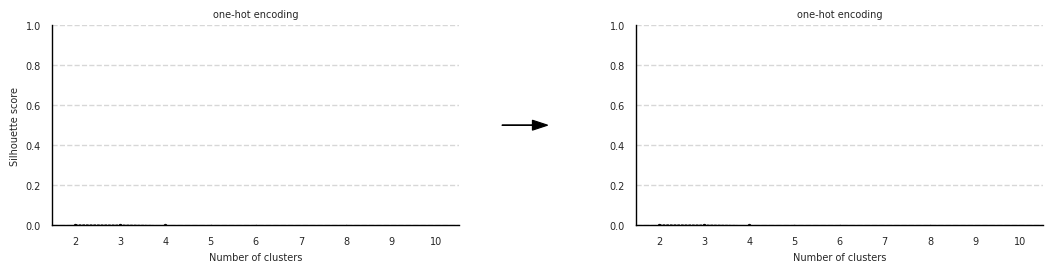

In [39]:
with paper_theme():
    fig = plt.figure(figsize=(text_width, 0.25*text_width))

    gs = fig.add_gridspec(1, 3, width_ratios=[1, 0.15, 1])

    def plot_kmeans(results, ax):
        ax = sns.barplot(
            data=results,
            x='n_clusters',
            y='silhouette',
            hue='n_clusters',
            ax=ax,
            palette='flare_r',
            legend=False,
            width=0.9,
        )

        ax = sns.pointplot(
            data=results,
            x='n_clusters',
            y='silhouette',
            ax=ax,
            color='black',
            markers='o',
            linestyles='--',
            linewidth=0.5,
            markersize=2,
        )

        ax.set_xlabel('Number of clusters', fontsize=7)
        ax.set_ylabel('Silhouette score', fontsize=7)
        ax.set_ylim(0, 1.0)

        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))

        return ax

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 2])

    ax1 = plot_kmeans(results, ax1)
    ax2 = plot_kmeans(results, ax2)

    ax1.set_title('one-hot encoding', fontsize=7)
    ax2.set_title('one-hot encoding', fontsize=7)
    ax2.set_ylabel('')

    ax1.tick_params(labelsize=7)
    ax2.tick_params(labelsize=7)

    ax_arrow = fig.add_subplot(gs[0, 1])
    ax_arrow.axis('off')
    ax_arrow.arrow(
        -0.25, 0.5, 0.75, 0,
        head_width=0.05, head_length=0.25,
        length_includes_head=True,
        fc='black', ec='black', transform=ax_arrow.transAxes,
        clip_on=False
    )

    fig.subplots_adjust(left=0.09, right=0.99, top=0.9, bottom=0.175)


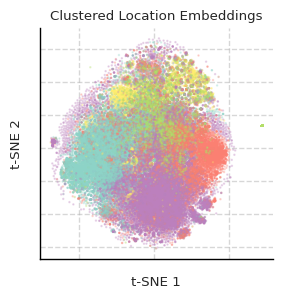

In [13]:
clustering_pipeline = skpipe.Pipeline(
    [
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_init='auto', n_clusters=5, random_state=42)),
    ]
)

embeddings_clusters = clustering_pipeline.fit_predict(embeddings_onehot)

tsne_pipeline = skpipe.Pipeline(
    [
        ('scaler', StandardScaler()),
        ('tsne', TSNE(n_components=2, n_jobs=-1, random_state=42)),
    ]
)

embeddings_tsne = tsne_pipeline.fit_transform(embeddings_onehot)

plt.close()
with paper_theme():
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    ax.scatter(
        embeddings_tsne[:, 0],
        embeddings_tsne[:, 1],
        alpha=0.25,
        s=1,
        c=embeddings_clusters,
        cmap='Set3',
    )


    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_title('Clustered Location Embeddings')

    ax.set_xticklabels([])
    ax.set_yticklabels([])

    plt.show()

In [4]:
sentences_uti = (
    sentences
    .pipe(labeller.label, args=args)
    .loc[lambda df: ~pd.isna(df['uti_label'])]

)
sentences_uti

,patient_id,start_date,location_name,location_list,location_str,uti_label
1033,2zbyXzYNKPwiPtjaA2L64o,2021-10-03,"[Bathroom, Kitchen, Nowhere, Nowhere, Nowhere,...","[Bathroom, Kitchen, Nowhere, Nowhere, Nowhere,...","Bathroom, Kitchen, Nowhere, Nowhere, Nowhere, ...",False
1063,2zbyXzYNKPwiPtjaA2L64o,2021-11-02,"[Nowhere, Nowhere, Bathroom, Nowhere, Nowhere,...","[Nowhere, Nowhere, Bathroom, Nowhere, Nowhere,...","Nowhere, Nowhere, Bathroom, Nowhere, Nowhere, ...",False
1147,2zbyXzYNKPwiPtjaA2L64o,2022-01-25,"[Nowhere, Nowhere, Bathroom, Nowhere, Nowhere,...","[Nowhere, Nowhere, Bathroom, Nowhere, Nowhere,...","Nowhere, Nowhere, Bathroom, Nowhere, Nowhere, ...",False
1182,2zbyXzYNKPwiPtjaA2L64o,2022-03-01,"[Hallway, Nowhere, Nowhere, Nowhere, Nowhere, ...","[Hallway, Nowhere, Nowhere, Nowhere, Nowhere, ...","Hallway, Nowhere, Nowhere, Nowhere, Nowhere, N...",False
1378,2zbyXzYNKPwiPtjaA2L64o,2022-09-13,"[Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, ...","[Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, ...","Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, N...",False
...,...,...,...,...,...,...
64816,YQb22UBcPbedJqEiKAqvDU,2023-07-18,"[Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, ...","[Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, ...","Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, N...",False
64864,YQb22UBcPbedJqEiKAqvDU,2023-09-04,"[Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, ...","[Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, ...","Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, N...",False
65276,YYGGmsEaf2gP4JNN9kMprV,2022-07-12,"[Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, ...","[Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, ...","Nowhere, Nowhere, Nowhere, Nowhere, Nowhere, B...",True
65430,YYGGmsEaf2gP4JNN9kMprV,2022-12-13,"[Bedroom, Nowhere, Nowhere, Nowhere, Nowhere, ...","[Bedroom, Nowhere, Nowhere, Nowhere, Nowhere, ...","Bedroom, Nowhere, Nowhere, Nowhere, Nowhere, N...",True


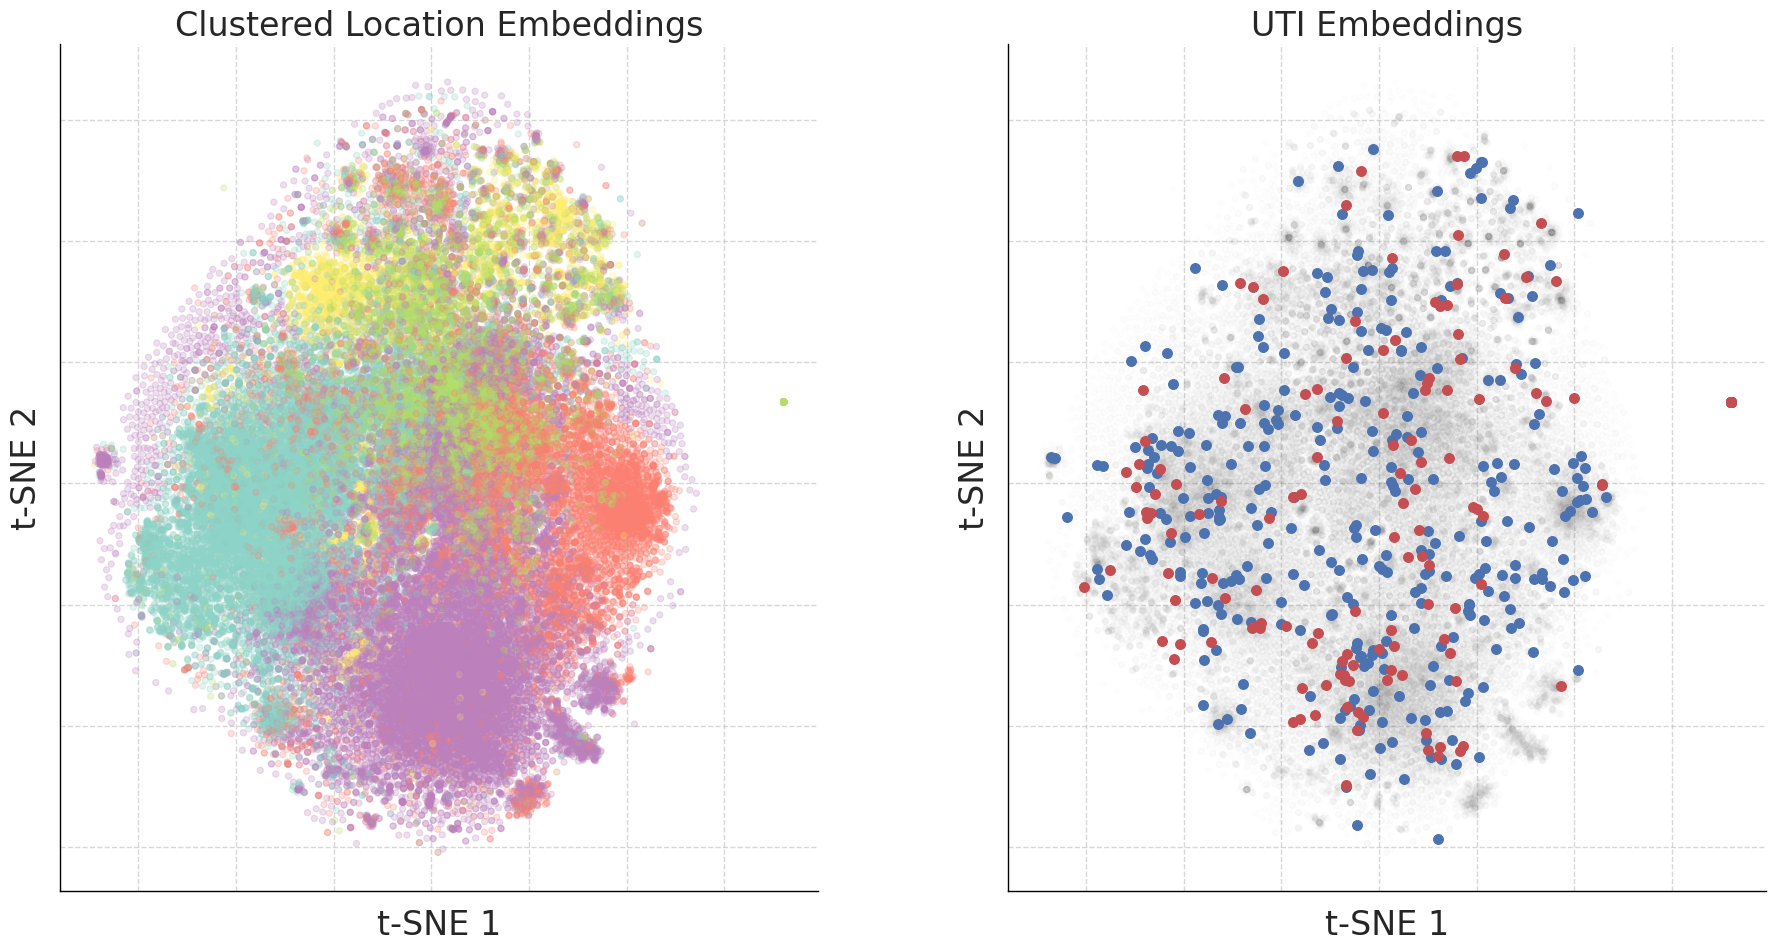

In [16]:
plt.close()

# Plot the first subplot
with paper_theme():
    # Filter embeddings based on uti_label
    colors = {True: 'r', False: 'b'}
    fontsize = 24
# Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(text_width*2, text_width))
    ax = axes[1]

    ax.scatter(
        embeddings_tsne[:, 0],
        embeddings_tsne[:, 1],
        alpha=0.01,
        s=20,
        c='gray',
    )
    for uti_label, group in sentences_uti.groupby('uti_label'):
        ax.scatter(embeddings_tsne[group.index.tolist(), 0], embeddings_tsne[group.index.tolist(), 1], c=colors[uti_label], label=uti_label, s=50)

    ax.set_xlabel('t-SNE 1', fontsize=fontsize)
    ax.set_ylabel('t-SNE 2', fontsize=fontsize)
    ax.set_title('UTI Embeddings', fontsize=fontsize)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax = axes[0]

    ax.scatter(
        embeddings_tsne[:, 0],
        embeddings_tsne[:, 1],
        alpha=0.25,
        s=20,
        c=embeddings_clusters,
        cmap='Set3',
    )

    ax.set_xlabel('t-SNE 1', fontsize=fontsize)
    ax.set_ylabel('t-SNE 2', fontsize=fontsize)
    ax.set_title('Clustered Location Embeddings', fontsize=fontsize)

    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.25)

plt.show()

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Filter embeddings based on uti_label
sentences_uti_indices = sentences_uti.index.tolist()
embeddings_filtered_onehot = embeddings_onehot[sentences_uti_indices]

# Perform t-SNE dimensionality reduction
tsne_pipeline = skpipe.Pipeline(
    [
        ('scaler', StandardScaler()),
        ('tsne', TSNE(n_components=2, n_jobs=-1, random_state=42)),
    ]
)
embeddings_tsne = tsne_pipeline.fit_transform(embeddings_filtered_onehot)
# 将 embeddings_tsne 转换为 DataFrame
embeddings_tsne_df = pd.DataFrame(embeddings_tsne, columns=['tsne_x', 'tsne_y'])

# 使用 pd.concat() 合并两个 DataFrame
sentences_uti_tsne_df = pd.concat([sentences_uti.reset_index(drop=True), embeddings_tsne_df], axis=1)
sentences_uti_tsne_df

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plt.close()
# 获取主图中所有点的数据
total_data = sentences_uti_tsne_df[['tsne_x', 'tsne_y', 'start_date']].copy()
with paper_theme():
  colors = {True: 'r', False: 'b'}
# 创建以tsne的xy值为坐标，uti_label为标签的二维图

  fig_total = plt.figure(figsize=(8, 6))
  ax_total = fig_total.add_subplot()
  for uti_label, group in sentences_uti_tsne_df.groupby('uti_label'):
      ax_total.scatter(group['tsne_x'], group['tsne_y'], c=colors[uti_label], label=uti_label)
  # 设置总图的图例
  ax_total.legend()

# 设置总图的坐标轴标签
  ax_total.set_xlabel('tsne_x')
  ax_total.set_ylabel('tsne_y')
  plt.show()

  # 计算子图数目
  num_patients = len(sentences_uti_tsne_df['patient_id'].unique())
  num_rows = (num_patients - 1) // 4 + 1
  fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20,  5*num_rows))

  # 按照uti_label用不同颜色绘制散点图，并将单独的病人图像放置在主图中
  for i, (patient_id, group) in enumerate(sentences_uti_tsne_df.groupby('patient_id')):
    row = i // 4
    col = i % 4
    ax = axes[row, col]

    # 设置子图的坐标轴范围与主图相同
    ax.set_xlim(ax_total.get_xlim())
    ax.set_ylim(ax_total.get_ylim())

    # 绘制分图中的散点图
    for uti_label, sub_group in group.groupby('uti_label'):
        ax.scatter(sub_group['tsne_x'], sub_group['tsne_y'], c=colors[uti_label], label=uti_label)

    # 将主图中的所有点以灰色显示在分图中
    ax.scatter(total_data['tsne_x'], total_data['tsne_y'], c='gray', alpha=0.3, label='Total Data')

    ax.set_xlabel('tsne_x')
    ax.set_ylabel('tsne_y')
    ax.set_title(patient_id)

# 调整子图之间的间距
  plt.tight_layout()

  plt.show()



In [ ]:

sentence_uti_classifier_df = (
    sentences_uti
    .assign(embedding_vector=embeddings_onehot[sentences_uti.index.tolist()].tolist())  # 添加 'embedding vector' 列，并提取相应行的行向量
    .assign(uti_label=sentences_uti['uti_label'].astype(int))  # 将 'uti_label' 列中的 True 和 False 转换为数值型 1 和 0
)
sentence_uti_classifier_df

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Define the task list
tasks = [
    {"task": "Get all data points", "start_date": "2024-05-01", "end_date": "2024-05-05"},
    {"task": "Classify data points", "start_date": "2024-05-06", "end_date": "2024-05-08"},
    {"task": "Preprocess data", "start_date": "2024-05-09", "end_date": "2024-05-15"},
    {"task": "Display data clustering in 2D/3D", "start_date": "2024-05-16", "end_date": "2024-05-20"},
    {"task": "Select optimal cluster number", "start_date": "2024-05-21", "end_date": "2024-05-24"},
    {"task": "Train five models and evaluate", "start_date": "2024-05-25", "end_date": "2024-06-05"},
    {"task": "Evaluate feature importance", "start_date": "2024-06-06", "end_date": "2024-06-10"},
    {"task": "Evaluate model performance and voting", "start_date": "2024-06-11", "end_date": "2024-06-15"},
    {"task": "Build test set and predict", "start_date": "2024-06-16", "end_date": "2024-06-20"},
    {"task": "Human expert scoring", "start_date": "2024-06-21", "end_date": "2024-06-25"},
    {"task": "Kappa coefficient analysis", "start_date": "2024-06-26", "end_date": "2024-06-30"}
]

# Convert date strings to datetime objects
for task in tasks:
    task["start_date"] = datetime.strptime(task["start_date"], "%Y-%m-%d")
    task["end_date"] = datetime.strptime(task["end_date"], "%Y-%m-%d")

with paper_theme():
# Create the Gantt chart
  fig, ax = plt.subplots(figsize=(text_width*2, text_width))

# Set ticks and labels for the Y-axis
  ax.yaxis.set_ticks(range(len(tasks)))
  ax.yaxis.set_ticklabels([task["task"] for task in tasks], fontsize=24)

# Draw the bars for the Gantt chart
  for i, task in enumerate(tasks):
    ax.barh(i, task["end_date"] - task["start_date"], left=task["start_date"], color='skyblue')

# Set the title and labels for the chart
  ax.set_xlabel('Time', fontsize=24)
  ax.set_title('Gantt Chart', fontsize=24)

# Format dates on the X-axis
  # Format dates on the X-axis
  date_format = mdates.DateFormatter('%Y-%m-%d')
  ax.xaxis.set_major_formatter(date_format)
  ax.xaxis_date()

# Set X-axis interval to 1 day
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))

# Show the chart
  plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def bland_altman_plot(true_scores, model_scores, title=''):
    mean_scores = np.mean([true_scores, model_scores], axis=0)
    diff_scores = true_scores - model_scores
    mean_diff = np.mean(diff_scores)
    std_diff = np.std(diff_scores, axis=0)

    plt.figure(figsize=(8, 6))
    plt.scatter(mean_scores, diff_scores, color='blue', alpha=0.6)
    plt.axhline(mean_diff, color='red', linestyle='--')
    plt.axhline(mean_diff + 1.96 * std_diff, color='green', linestyle='--')
    plt.axhline(mean_diff - 1.96 * std_diff, color='green', linestyle='--')
    plt.xlabel('Mean of true and model scores')
    plt.ylabel('Difference between true and model scores')
    plt.title(title)
    plt.grid(True)
    plt.show()

# 使用示例
true_scores = np.random.randint(0, 100, size=100)
model_scores = true_scores + np.random.normal(0, 5, size=100)  # 假设模型的评分有一些误差
with paper_theme():
  bland_altman_plot(true_scores, model_scores, title='Bland-Altman Plot')


MLP 模型参数: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 100, 10), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
MLP 模型准确率: [0.68421053 0.68421053 0.64       0.68       0.69333333]
MLP 模型召回率: [0.33333333 0.14285714 0.14285714 0.23809524 0.19047619]
MLP 模型 F1 分数: [0.36842105 0.2        0.18181818 0.29411765 0.25806452]


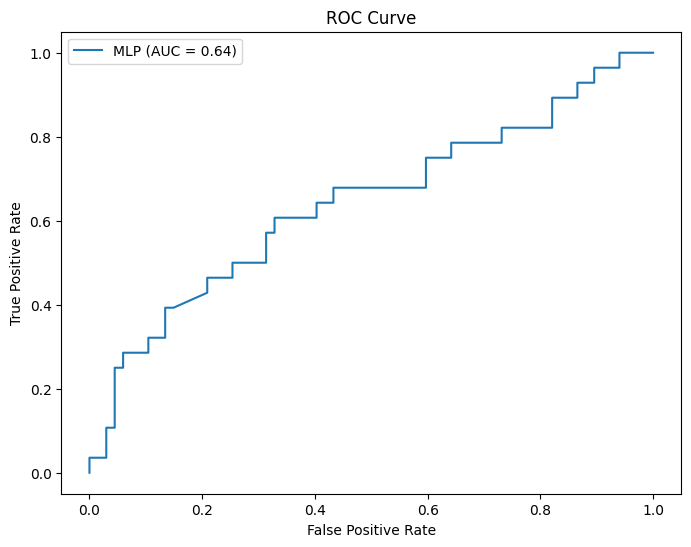

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import auc
import warnings
warnings.filterwarnings("ignore")


# 准备数据
X_origin = np.array(sentence_uti_classifier_df['embedding_vector'].tolist())
y_origin = np.array(sentence_uti_classifier_df['uti_label'])

X, X_test, y, y_test = train_test_split(X_origin, y_origin, test_size=0.2, random_state=42)


# 初始化模型

mlp_model = MLPClassifier(hidden_layer_sizes=(100, 100, 10), learning_rate_init=0.001, max_iter=200, random_state=42)


cross_validation_fold = 5



# 训练和评估 MLP 模型
mlp_model.fit(X, y)
print("MLP 模型参数:", mlp_model.get_params())
mlp_scores = cross_val_score(mlp_model, X, y, cv=cross_validation_fold, scoring='accuracy')
mlp_recall = cross_val_score(mlp_model, X, y, cv=cross_validation_fold, scoring='recall')
mlp_f1 = cross_val_score(mlp_model, X, y, cv=cross_validation_fold, scoring='f1')

mlp_scores_onehot = mlp_scores
mlp_recall_onehot = mlp_recall
mlp_f1_onehot = mlp_f1

# 输出结果


print("MLP 模型准确率:", mlp_scores)
print("MLP 模型召回率:", mlp_recall)
print("MLP 模型 F1 分数:", mlp_f1)





mlp_probs = mlp_model.predict_proba(X_test)[:, 1]
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_probs)



# 计算每个模型的AUC值
mlp_auc = auc(mlp_fpr, mlp_tpr)
# 绘制 ROC 曲线并在图中添加AUC值
plt.figure(figsize=(8, 6))
plt.plot(mlp_fpr, mlp_tpr, label=f'MLP (AUC = {mlp_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [50]:
# 计算每个数组的均值和置信区间
def calculate_confidence_interval(data):
    std_dev = np.std(data, ddof=1)
    std_error = std_dev / np.sqrt(len(data))
    margin_of_error = 1.96 * std_error
    confidence_interval = (np.mean(data) - margin_of_error, np.mean(data) + margin_of_error)
    return confidence_interval

# 计算均值和置信区间边界的距离
def calculate_distance(mean, interval):
    lower_bound, upper_bound = interval
    distance_lower = mean - lower_bound
    distance_upper = upper_bound - mean
    return distance_lower, distance_upper

# 计算并输出结果
def print_mean_and_interval(data):
    mean = np.mean(data)
    interval = calculate_confidence_interval(data)
    distance_lower, distance_upper = calculate_distance(mean, interval)
    print(f"mean+-interval: {mean:.2f}+{distance_upper:.2f}-{distance_lower:.2f}")

print("mlp_scores_onehot:")
print_mean_and_interval(mlp_scores_onehot)

print("mlp_recall_onehot:")
print_mean_and_interval(mlp_recall_onehot)

print("mlp_f1_onehot:")
print_mean_and_interval(mlp_f1_onehot)

mlp_scores_onehot:
mean+-interval: 0.68+0.02-0.02
mlp_recall_onehot:
mean+-interval: 0.21+0.07-0.07
mlp_f1_onehot:
mean+-interval: 0.26+0.07-0.07


In [13]:
embeddings_fine_tune = np.load('embeddings_fine_tune.npy')

In [ ]:
sentence_uti_classifier_df_finetune = (
    sentences_uti
    .assign(embedding_vector=embeddings_fine_tune[sentences_uti.index.tolist()].tolist())  # 添加 'embedding vector' 列，并提取相应行的行向量
    .assign(uti_label=sentences_uti['uti_label'].astype(int))  # 将 'uti_label' 列中的 True 和 False 转换为数值型 1 和 0
)
sentence_uti_classifier_df_finetune

MLP 模型准确率: [0.71052632 0.72368421 0.69333333 0.74666667 0.68      ]
MLP 模型召回率: [0.14285714 0.14285714 0.23809524 0.14285714 0.14285714]
MLP 模型 F1 分数: [0.21428571 0.22222222 0.3030303  0.24       0.2       ]


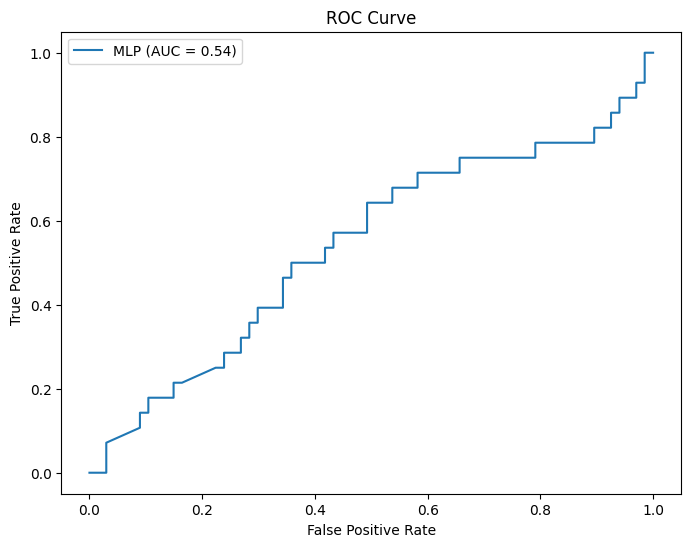

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import auc
import warnings
warnings.filterwarnings("ignore")


# 准备数据
X_origin = np.array(sentence_uti_classifier_df_finetune['embedding_vector'].tolist())
y_origin = np.array(sentence_uti_classifier_df_finetune['uti_label'])

X, X_test, y, y_test = train_test_split(X_origin, y_origin, test_size=0.2, random_state=42)


# 初始化模型

mlp_model = MLPClassifier(hidden_layer_sizes=(100, 100, 10), learning_rate_init=0.001, max_iter=200, random_state=42)


cross_validation_fold = 5


# 训练和评估 MLP 模型
mlp_scores = cross_val_score(mlp_model, X, y, cv=cross_validation_fold, scoring='accuracy')
mlp_recall = cross_val_score(mlp_model, X, y, cv=cross_validation_fold, scoring='recall')
mlp_f1 = cross_val_score(mlp_model, X, y, cv=cross_validation_fold, scoring='f1')

mlp_scores_llmencoder = mlp_scores
mlp_recall_llmencoder = mlp_recall
mlp_f1_llmencoder = mlp_f1
# 输出结果


print("MLP 模型准确率:", mlp_scores)
print("MLP 模型召回率:", mlp_recall)
print("MLP 模型 F1 分数:", mlp_f1)


# 绘制 ROC 曲线

mlp_model.fit(X, y)
mlp_probs = mlp_model.predict_proba(X_test)[:, 1]
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_probs)



# 计算每个模型的AUC值

mlp_auc = auc(mlp_fpr, mlp_tpr)

# 绘制 ROC 曲线并在图中添加AUC值
plt.figure(figsize=(8, 6))
plt.plot(mlp_fpr, mlp_tpr, label=f'MLP (AUC = {mlp_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [49]:
# 计算每个数组的均值和置信区间
def calculate_confidence_interval(data):
    std_dev = np.std(data, ddof=1)
    std_error = std_dev / np.sqrt(len(data))
    margin_of_error = 1.96 * std_error
    confidence_interval = (np.mean(data) - margin_of_error, np.mean(data) + margin_of_error)
    return confidence_interval

# 计算均值和置信区间边界的距离
def calculate_distance(mean, interval):
    lower_bound, upper_bound = interval
    distance_lower = mean - lower_bound
    distance_upper = upper_bound - mean
    return distance_lower, distance_upper

# 计算并输出结果
def print_mean_and_interval(data):
    mean = np.mean(data)
    interval = calculate_confidence_interval(data)
    distance_lower, distance_upper = calculate_distance(mean, interval)
    print(f"mean+-interval: {mean:.2f}+{distance_upper:.2f}-{distance_lower:.2f}")

print("mlp_scores_llmencoder:")
print_mean_and_interval(mlp_scores_llmencoder)

print("mlp_recall_llmencoder:")
print_mean_and_interval(mlp_recall_llmencoder)

print("mlp_f1_llmencoder:")
print_mean_and_interval(mlp_f1_llmencoder)

mlp_scores_llmencoder:
mean+-interval: 0.71+0.02-0.02
mlp_recall_llmencoder:
mean+-interval: 0.16+0.04-0.04
mlp_f1_llmencoder:
mean+-interval: 0.24+0.04-0.04


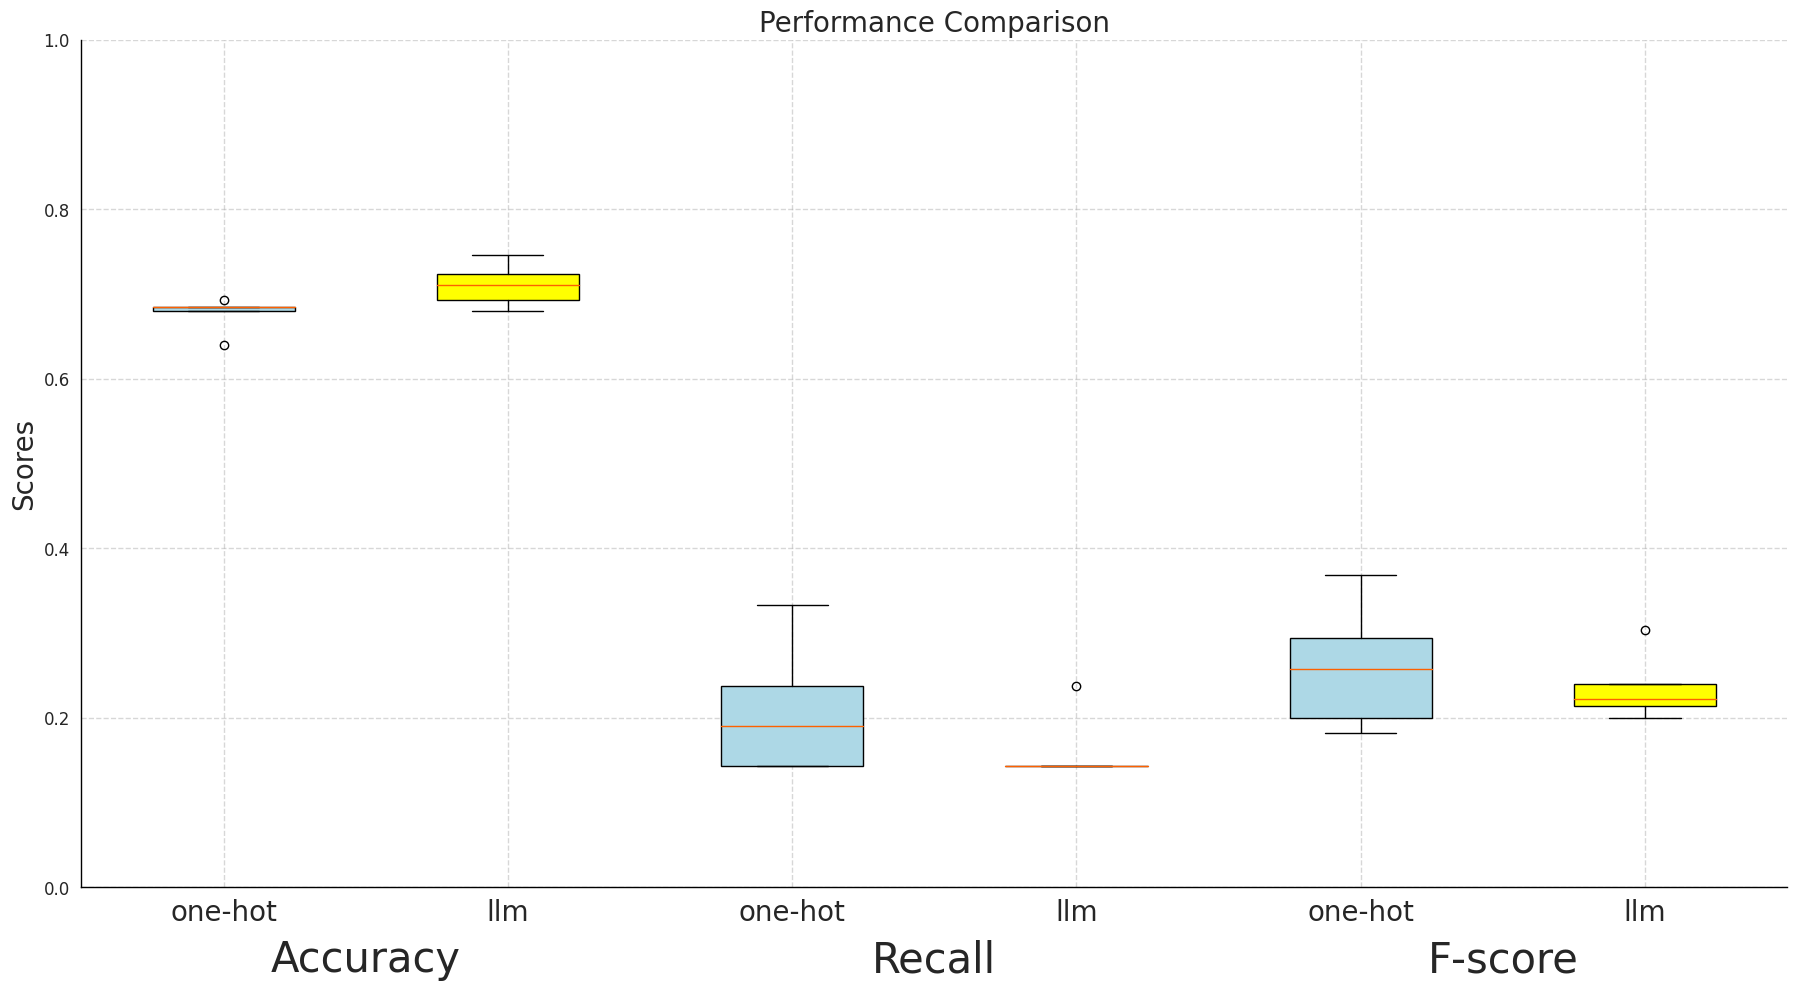

In [51]:
import matplotlib.pyplot as plt

with paper_theme():
    # 绘制箱线图
    plt.figure(figsize=(text_width*2, text_width))

    # 绘制箱图并指定箱子的填充颜色
    box = plt.boxplot([mlp_scores_onehot, mlp_scores_llmencoder,
                   mlp_recall_onehot, mlp_recall_llmencoder,
                   mlp_f1_onehot, mlp_f1_llmencoder],
                  labels=['one-hot', 'llm',
                          'one-hot', 'llm',
                          'one-hot', 'llm'],
                  patch_artist=True)  # 启用填充箱子

# 设置箱子的填充颜色
    colors = ['lightblue', 'yellow', 'lightblue', 'yellow', 'lightblue', 'yellow']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

# 设置标题、标签和刻度
    plt.title('Performance Comparison', fontsize=20)
    plt.ylabel('Scores', fontsize=20)
    plt.ylim(0, 1)  # 设置y轴刻度范围为0到1
    plt.xticks(rotation=0, fontsize=20)  # 旋转x轴标签以便更好地显示
    plt.yticks(fontsize=12)
    plt.grid(True)

# 添加副标题
    plt.text(1.5, -0.1, 'Accuracy', fontsize=30, ha='center')
    plt.text(3.5, -0.1, 'Recall', fontsize=30, ha='center')
    plt.text(5.5, -0.1, 'F-score', fontsize=30, ha='center')

    plt.show()


